In [ ]:
from math import sqrt
from numpy import array
from numpy import mean
from numpy import std
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from matplotlib import pyplot
from keras.models import load_model

In [ ]:
from google.colab import files

files.upload()

Saving 상명대_전력수요예측_지수평활 sheet1.xlsx to 상명대_전력수요예측_지수평활 sheet1.xlsx


{'상명대_전력수요예측_지수평활 sheet1.xlsx': b'PK\x03\x04\x14\x00\x06\x00\x08\x00\x00\x00!\x00\x9e,lok\x01\x00\x00\x10\x05\x00\x00\x13\x00\x08\x02[Content_Types].xml \xa2\x04\x02(\xa0\x00\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.chdir("/content/drive/MyDrive/PowerModel")

In [ ]:
# 데이터 입력 
import openpyxl
filename = "상명대_전력수요예측_지수평활 sheet1.xlsx" 
book = openpyxl.load_workbook(filename) #엑셀파일 book 변수에 저장
sheet=book.worksheets[0] #첫번째 워크시트 저장

In [ ]:
 data = []
 for row in sheet.rows: #전체 행에대하여 반복 실행
   data.append([
              row[0].value, #1열 데이터
              row[1].value, #2열 데이터
              row[2].value, #3열 데이터
              row[3].value, #4열 데이터
              row[4].value, #5열 데이터
              row[5].value  #6열 데이터
              ])

In [ ]:
import math
import pandas as pd
import numpy as np
data=pd.DataFrame(data[3:])
data.columns=["Name","No","Date","Time","P.D","Temp"]
data

Name  No       Date  Time       P.D  Temp
0      신정   8 2018-01-01     1  6151.290  -3.2
1      신정   8 2018-01-01     2  6035.190  -3.3
2      신정   8 2018-01-01     3  6000.090  -3.7
3      신정   8 2018-01-01     4  5970.930  -4.0
4      신정   8 2018-01-01     5  6025.200  -4.2
...   ...  ..        ...   ...       ...   ...
8755    0   1 2018-12-31    20  7457.955  -3.7
8756    0   1 2018-12-31    21  7005.975  -4.6
8757    0   1 2018-12-31    22  6709.110  -5.4
8758    0   1 2018-12-31    23  6332.730  -5.2
8759    0   1 2018-12-31    24  6096.750  -5.5

[8760 rows x 6 columns]

#**전력만 사용**

In [ ]:
columns = ['P.D']
data_ = data[columns]
data_

P.D
0     6151.290
1     6035.190
2     6000.090
3     5970.930
4     6025.200
...        ...
8755  7457.955
8756  7005.975
8757  6709.110
8758  6332.730
8759  6096.750

[8760 rows x 1 columns]

In [ ]:
# split a univariate dataset into train/test sets
def train_test_split(data):
  train=int(len(data)*0.8) #train
  return data[:train],data[train:]


In [ ]:
train,test = train_test_split(data_)
print(train)
print(test)

           P.D
0     6151.290
1     6035.190
2     6000.090
3     5970.930
4     6025.200
...        ...
7003  8038.455
7004  7581.210
7005  7231.965
7006  6476.775
7007  6084.600

[7008 rows x 1 columns]
           P.D
7008  5789.355
7009  5743.860
7010  5701.200
7011  5713.080
7012  5853.345
...        ...
8755  7457.955
8756  7005.975
8757  6709.110
8758  6332.730
8759  6096.750

[1752 rows x 1 columns]


In [ ]:
# transform list into supervised learning format
def series_to_supervised(m_data, n_in, n_out=1):
	m_data.dropna(inplace=True)
	train_series = [] 
	target_series = [] 
  
	for i in range(0, n_in-1):
		row = [] # row represents a train series, in this case, [[111, -1], [112, -2]]
		count = i # count is the variable to access the target value, in this case, 113
		for j in range(2):
        # a row = [111, -1]
			row.append([value for value in m_data.iloc[i+j]])
			count += 1
		train_series.append(row)
		target_series.append(m_data.iloc[count].values[0])
    # ----

	train_series = np.array(train_series, dtype="float32")
	target_series = np.array(target_series, dtype="float32");print(train_series,target_series)
	return train_series, target_series

In [ ]:
data_

P.D
0     6151.290
1     6035.190
2     6000.090
3     5970.930
4     6025.200
...        ...
8755  7457.955
8756  7005.975
8757  6709.110
8758  6332.730
8759  6096.750

[8760 rows x 1 columns]

In [ ]:
series_to_supervised(data_,2)

[[[6151.29]
  [6035.19]]] [6000.09]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


(array([[[6151.29],
         [6035.19]]], dtype=float32), array([6000.09], dtype=float32))

In [ ]:
def measure_error(actual, predicted):
  actual=np.array(actual)
  predicted=np.array(predicted)
  result=np.mean(np.abs((actual-predicted)/actual)*100)
  return result

In [ ]:
# fit a model
def model_fit(train, config):  
	# unpack config
	n_seq, n_steps, n_filters, n_kernel, n_nodes, n_epochs, n_batch = config  #config = [1, 2, 64, 3, 200, 350, 100]
	n_input = n_seq * n_steps
	# prepare data
	data = series_to_supervised(train, n_input,1)
	train_x, train_y = data[:-1], data[-1]  #train중, data[:, :-1]=마지막값 제외, data[:, -1]=마지막값
	train_x = np.asarray(train_x) ; print(train_x)
	train_x = train_x.reshape((train_x.shape[0], n_seq, n_steps, 1));print(train_x,data)  #input

  # define model
	model = Sequential()
 #TimeDistributed= 각 스텝마다 cost(오류)를 계산해서 하위 스텝으로 오류를 전파하여 각 weight를 업데이트하라는 의미
	model.add(TimeDistributed(Conv1D(n_filters, n_kernel,padding='same',activation='relu', input_shape=(None,n_steps,1))))
	# model.add(TimeDistributed(Conv1D(n_filters, n_kernel, activation='relu')))
	model.add(TimeDistributed(Conv1D(n_filters, n_kernel,padding='same',activation='relu')))
#	model.add(TimeDistributed(Conv1D(n_filters, n_kernel, activation='relu')))
	model.add(TimeDistributed(MaxPooling1D()))
	model.add(TimeDistributed(Flatten()))
	model.add(LSTM(n_nodes, activation='relu'))
	model.add(Dense(n_nodes, activation='relu'))
	model.add(Dense(1))
	model.compile(loss='mse', optimizer='adam')
	# fit
	model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=1); model.save("./save_model")
	return model

In [ ]:
# forecast with a pre-fit model
def model_predict(model, history, config):  
	# unpack config
	n_seq, n_steps, _, _, _, _, _ = config
	n_input = n_seq * n_steps
	# prepare data
	x_input = array(history[-n_input:]).reshape((1, n_seq, n_steps, 1))
	# forecast
	yhat = model.predict(x_input,verbose=0)
	return yhat[0]

In [ ]:
import matplotlib.pyplot as plt
def draw_graph(test,predictions):
	fig = plt.figure(figsize=(10, 5))
	ax1 = fig.add_subplot(1, 1, 1)
	ax1.plot(test, 'b', label='Original')
	ax1.plot(predictions, 'r', label='Prediction')
	ax1.legend(loc="lower right")

In [ ]:
# walk-forward validation for univariate(단변량=종속변수 한개) data
#학습 및 에러계산
def walk_forward_validation(data, n_test, cfg):   
	predictions = list()
	# split dataset
	train, test = train_test_split(data) 
	# fit model
	model = model_fit(train, cfg) ; model.summary()
	print('finish training')
	# seed history with training dataset
	history = [x for x in train.values] 
	test=[x for x in test.values]  

	# step over each time-step in the test set
	for i in range(len(test)):
		yhat = model_predict(model, history, cfg)
		# store forecast in list of, 예측값모음=predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
		test_=np.array(test)

	# estimate prediction errorrint("pre") 에러율 계산 
	error = measure_error(test_, predictions)  
	print(' > %.3f' % error)
	draw_graph(test_,predictions)
	print(test_)
	print(predictions)
	return error

In [ ]:
# repeat evaluation of a config
#전체 에러 계산 
def repeat_evaluate(data, config, n_test, n_repeats=10):
	# fit and evaluate the model n times
	scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]  #error 저장
	return scores

In [ ]:
# summarize model performance
def summarize_scores(name, scores):
	# print a summary
	scores_m, score_std = mean(scores), std(scores)
	print('%s: %.3f error (+/- %.3f)' % (name, scores_m, score_std))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


[[[6151.29]
  [6035.19]]] [6000.09]
[[[[6151.29]
   [6035.19]]]]
[[[[6151.29]
   [6035.19]]]] (array([[[6151.29],
        [6035.19]]], dtype=float32), array([6000.09], dtype=float32))
Epoch 1/350
1/1 [==============================] - 1s 1s/step - loss: 35544892.0000
Epoch 2/350
1/1 [==============================] - 0s 7ms/step - loss: 34550212.0000
Epoch 3/350
1/1 [==============================] - 0s 9ms/step - loss: 33637336.0000
Epoch 4/350
1/1 [==============================] - 0s 7ms/step - loss: 32540568.0000
Epoch 5/350
1/1 [==============================] - 0s 11ms/step - loss: 31033892.0000
Epoch 6/350
1/1 [==============================] - 0s 9ms/step - loss: 29463910.0000
Epoch 7/350
1/1 [==============================] - 0s 5ms/step - loss: 28039446.0000
Epoch 8/350
1/1 [==============================] - 0s 7ms/step - loss: 26465690.0000
Epoch 9/350
1/1 [==============================] - 0s 13ms/step - loss: 24414122.0000
Epoch 10/350
1/1 [==============================] 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/350
1/1 [==============================] - 1s 1s/step - loss: 35083844.0000
Epoch 2/350
1/1 [==============================] - 0s 14ms/step - loss: 34020956.0000
Epoch 3/350
1/1 [==============================] - 0s 8ms/step - loss: 33081948.0000
Epoch 4/350
1/1 [==============================] - 0s 12ms/step - loss: 32183416.0000
Epoch 5/350
1/1 [==============================] - 0s 8ms/step - loss: 31238062.0000
Epoch 6/350
1/1 [==============================] - 0s 12ms/step - loss: 30198202.0000
Epoch 7/350
1/1 [==============================] - 0s 10ms/step - loss: 29070204.0000
Epoch 8/350
1/1 [==============================] - 0s 7ms/step - loss: 27821910.0000
Epoch 9/350
1/1 [==============================] - 0s 7ms/step - loss: 26323738.0000
Epoch 10/350
1/1 [==============================] - 0s 9ms/step - loss: 24693794.0000
Epoch 11/350
1/1 [==============================] - 0s 9ms/step - loss: 22919656.0000
Epoch 12/350
1/1 [==============================] - 0s 8ms/s

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/350
1/1 [==============================] - 1s 1s/step - loss: 35367812.0000
Epoch 2/350
1/1 [==============================] - 0s 12ms/step - loss: 33962448.0000
Epoch 3/350
1/1 [==============================] - 0s 10ms/step - loss: 32693760.0000
Epoch 4/350
1/1 [==============================] - 0s 7ms/step - loss: 31687422.0000
Epoch 5/350
1/1 [==============================] - 0s 11ms/step - loss: 30278882.0000
Epoch 6/350
1/1 [==============================] - 0s 11ms/step - loss: 28647060.0000
Epoch 7/350
1/1 [==============================] - 0s 10ms/step - loss: 26768856.0000
Epoch 8/350
1/1 [==============================] - 0s 7ms/step - loss: 24650124.0000
Epoch 9/350
1/1 [==============================] - 0s 6ms/step - loss: 22312310.0000
Epoch 10/350
1/1 [==============================] - 0s 8ms/step - loss: 19712884.0000
Epoch 11/350
1/1 [==============================] - 0s 7ms/step - loss: 16940604.0000
Epoch 12/350
1/1 [==============================] - 0s 11ms

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/350
1/1 [==============================] - 1s 1s/step - loss: 36201000.0000
Epoch 2/350
1/1 [==============================] - 0s 9ms/step - loss: 34852956.0000
Epoch 3/350
1/1 [==============================] - 0s 8ms/step - loss: 33949752.0000
Epoch 4/350
1/1 [==============================] - 0s 8ms/step - loss: 32999330.0000
Epoch 5/350
1/1 [==============================] - 0s 16ms/step - loss: 32065378.0000
Epoch 6/350
1/1 [==============================] - 0s 11ms/step - loss: 31065404.0000
Epoch 7/350
1/1 [==============================] - 0s 8ms/step - loss: 29945626.0000
Epoch 8/350
1/1 [==============================] - 0s 10ms/step - loss: 28695064.0000
Epoch 9/350
1/1 [==============================] - 0s 8ms/step - loss: 27334536.0000
Epoch 10/350
1/1 [==============================] - 0s 7ms/step - loss: 25828382.0000
Epoch 11/350
1/1 [==============================] - 0s 7ms/step - loss: 24149412.0000
Epoch 12/350
1/1 [==============================] - 0s 8ms/st

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/350
1/1 [==============================] - 1s 1s/step - loss: 35930940.0000
Epoch 2/350
1/1 [==============================] - 0s 9ms/step - loss: 34501896.0000
Epoch 3/350
1/1 [==============================] - 0s 12ms/step - loss: 33702156.0000
Epoch 4/350
1/1 [==============================] - 0s 10ms/step - loss: 32997430.0000
Epoch 5/350
1/1 [==============================] - 0s 7ms/step - loss: 32139638.0000
Epoch 6/350
1/1 [==============================] - 0s 7ms/step - loss: 31064294.0000
Epoch 7/350
1/1 [==============================] - 0s 11ms/step - loss: 29951724.0000
Epoch 8/350
1/1 [==============================] - 0s 11ms/step - loss: 28686348.0000
Epoch 9/350
1/1 [==============================] - 0s 13ms/step - loss: 27225812.0000
Epoch 10/350
1/1 [==============================] - 0s 14ms/step - loss: 25218188.0000
Epoch 11/350
1/1 [==============================] - 0s 12ms/step - loss: 23309768.0000
Epoch 12/350
1/1 [==============================] - 0s 8m

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/350
1/1 [==============================] - 2s 2s/step - loss: 35361932.0000
Epoch 2/350
1/1 [==============================] - 0s 15ms/step - loss: 34443940.0000
Epoch 3/350
1/1 [==============================] - 0s 8ms/step - loss: 33669776.0000
Epoch 4/350
1/1 [==============================] - 0s 15ms/step - loss: 32738596.0000
Epoch 5/350
1/1 [==============================] - 0s 10ms/step - loss: 31767858.0000
Epoch 6/350
1/1 [==============================] - 0s 8ms/step - loss: 30681852.0000
Epoch 7/350
1/1 [==============================] - 0s 11ms/step - loss: 29411354.0000
Epoch 8/350
1/1 [==============================] - 0s 12ms/step - loss: 27923304.0000
Epoch 9/350
1/1 [==============================] - 0s 11ms/step - loss: 26214990.0000
Epoch 10/350
1/1 [==============================] - 0s 9ms/step - loss: 24267434.0000
Epoch 11/350
1/1 [==============================] - 0s 8ms/step - loss: 22092786.0000
Epoch 12/350
1/1 [==============================] - 0s 9ms

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/350
1/1 [==============================] - 1s 1s/step - loss: 36005672.0000
Epoch 2/350
1/1 [==============================] - 0s 13ms/step - loss: 34829004.0000
Epoch 3/350
1/1 [==============================] - 0s 7ms/step - loss: 33551602.0000
Epoch 4/350
1/1 [==============================] - 0s 13ms/step - loss: 32327704.0000
Epoch 5/350
1/1 [==============================] - 0s 12ms/step - loss: 31055614.0000
Epoch 6/350
1/1 [==============================] - 0s 8ms/step - loss: 29695178.0000
Epoch 7/350
1/1 [==============================] - 0s 8ms/step - loss: 28162658.0000
Epoch 8/350
1/1 [==============================] - 0s 8ms/step - loss: 26392902.0000
Epoch 9/350
1/1 [==============================] - 0s 8ms/step - loss: 24377054.0000
Epoch 10/350
1/1 [==============================] - 0s 9ms/step - loss: 22104420.0000
Epoch 11/350
1/1 [==============================] - 0s 9ms/step - loss: 18961020.0000
Epoch 12/350
1/1 [==============================] - 0s 9ms/st

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


 [6000.09]
[[[[6151.29]
   [6035.19]]]]
[[[[6151.29]
   [6035.19]]]] (array([[[6151.29],
        [6035.19]]], dtype=float32), array([6000.09], dtype=float32))
Epoch 1/350
1/1 [==============================] - 1s 1s/step - loss: 36042832.0000
Epoch 2/350
1/1 [==============================] - 0s 10ms/step - loss: 35676640.0000
Epoch 3/350
1/1 [==============================] - 0s 12ms/step - loss: 34894416.0000
Epoch 4/350
1/1 [==============================] - 0s 11ms/step - loss: 34237736.0000
Epoch 5/350
1/1 [==============================] - 0s 10ms/step - loss: 33534216.0000
Epoch 6/350
1/1 [==============================] - 0s 11ms/step - loss: 32690666.0000
Epoch 7/350
1/1 [==============================] - 0s 11ms/step - loss: 31648778.0000
Epoch 8/350
1/1 [==============================] - 0s 12ms/step - loss: 30538586.0000
Epoch 9/350
1/1 [==============================] - 0s 20ms/step - loss: 29278646.0000
Epoch 10/350
1/1 [==============================] - 0s 8ms/step - los

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/350
1/1 [==============================] - 1s 1s/step - loss: 35842836.0000
Epoch 2/350
1/1 [==============================] - 0s 10ms/step - loss: 34852684.0000
Epoch 3/350
1/1 [==============================] - 0s 8ms/step - loss: 33918432.0000
Epoch 4/350
1/1 [==============================] - 0s 6ms/step - loss: 32979128.0000
Epoch 5/350
1/1 [==============================] - 0s 17ms/step - loss: 31904426.0000
Epoch 6/350
1/1 [==============================] - 0s 7ms/step - loss: 30801834.0000
Epoch 7/350
1/1 [==============================] - 0s 7ms/step - loss: 29524912.0000
Epoch 8/350
1/1 [==============================] - 0s 10ms/step - loss: 28016232.0000
Epoch 9/350
1/1 [==============================] - 0s 5ms/step - loss: 26282514.0000
Epoch 10/350
1/1 [==============================] - 0s 11ms/step - loss: 24297842.0000
Epoch 11/350
1/1 [==============================] - 0s 11ms/step - loss: 22069864.0000
Epoch 12/350
1/1 [==============================] - 0s 13ms

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/350
1/1 [==============================] - 2s 2s/step - loss: 36106920.0000
Epoch 2/350
1/1 [==============================] - 0s 17ms/step - loss: 35357112.0000
Epoch 3/350
1/1 [==============================] - 0s 10ms/step - loss: 34692876.0000
Epoch 4/350
1/1 [==============================] - 0s 8ms/step - loss: 33857704.0000
Epoch 5/350
1/1 [==============================] - 0s 8ms/step - loss: 33148110.0000
Epoch 6/350
1/1 [==============================] - 0s 8ms/step - loss: 32317332.0000
Epoch 7/350
1/1 [==============================] - 0s 12ms/step - loss: 31456296.0000
Epoch 8/350
1/1 [==============================] - 0s 8ms/step - loss: 30489454.0000
Epoch 9/350
1/1 [==============================] - 0s 8ms/step - loss: 29317962.0000
Epoch 10/350
1/1 [==============================] - 0s 8ms/step - loss: 28045966.0000
Epoch 11/350
1/1 [==============================] - 0s 8ms/step - loss: 26599792.0000
Epoch 12/350
1/1 [==============================] - 0s 8ms/st

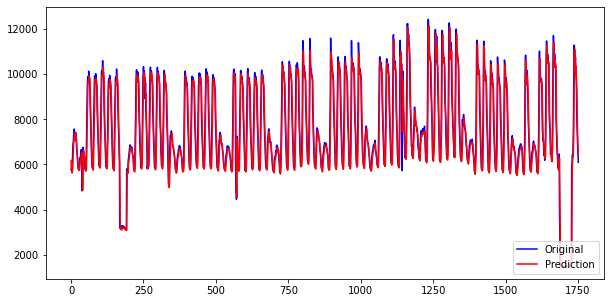

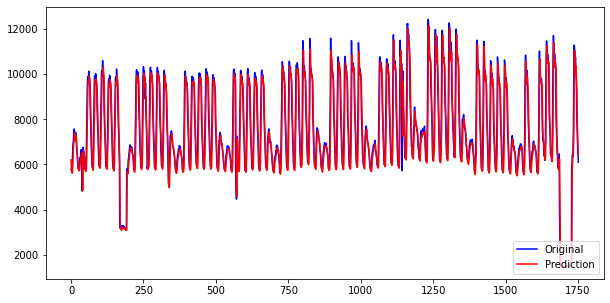

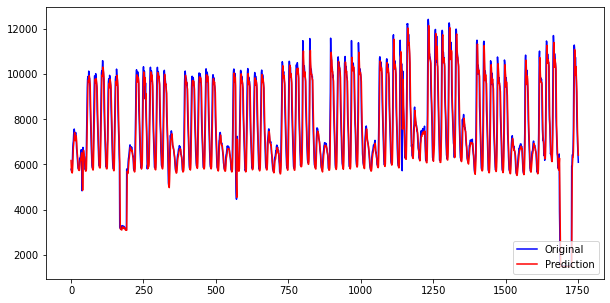

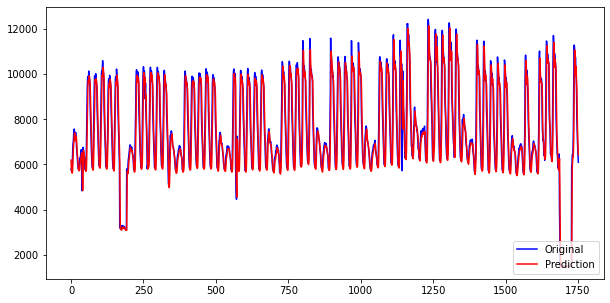

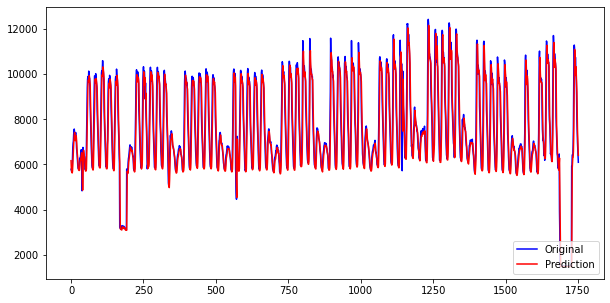

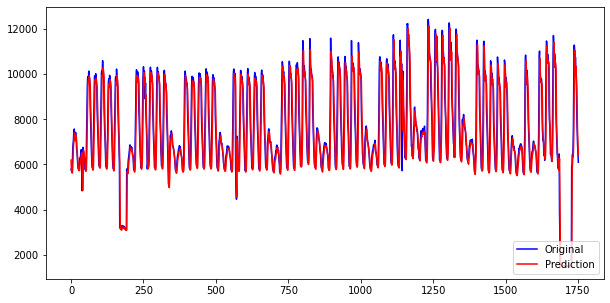

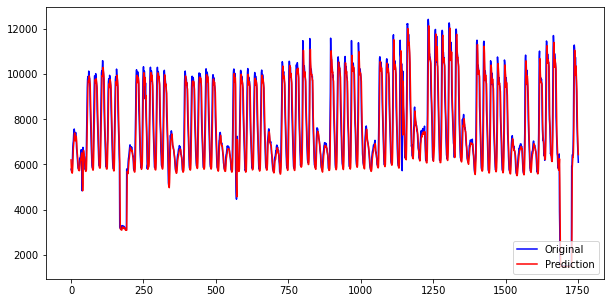

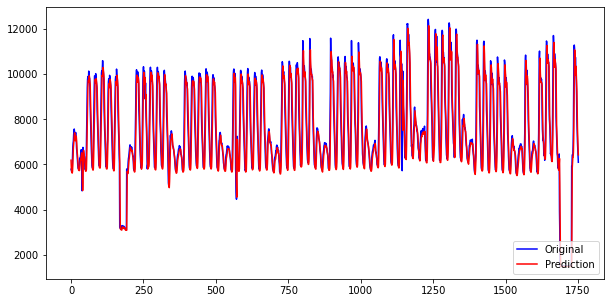

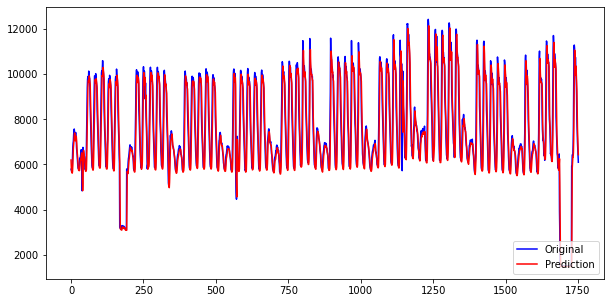

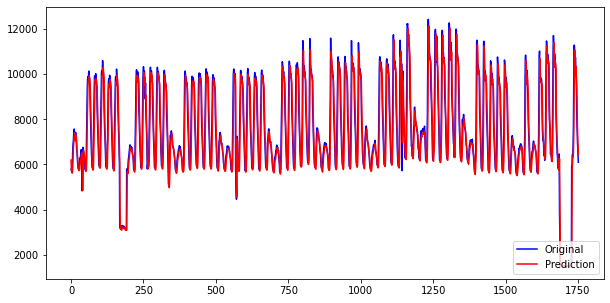

In [ ]:
from tensorflow.python.keras.callbacks import EarlyStopping
# data split
n_test = 2

# define config 
# n seq: The number of subsequences within a sample.
# n steps: The number of time steps within each subsequence.
# n filters: The number of parallel filters.
# n kernel: The number of time steps considered in each read of the input sequence.
# n nodes: The number of LSTM units to use in the hidden layer.
# n epochs: The number of times to expose the model to the whole training dataset.
# n batch: The number of samples within an epoch after which the weights are updated.

config = [1, 2, 64, 3, 200, 350, 100]
# grid search
scores = repeat_evaluate(data_, config, n_test)
# summarize scores
summarize_scores('cnn-lstm', scores)
# model.save("./save_model")

# **전력+온도**

In [ ]:
columns = ['P.D', 'Temp']
data2 = data[columns]
data2

P.D  Temp
0     6151.290  -3.2
1     6035.190  -3.3
2     6000.090  -3.7
3     5970.930  -4.0
4     6025.200  -4.2
...        ...   ...
8755  7457.955  -3.7
8756  7005.975  -4.6
8757  6709.110  -5.4
8758  6332.730  -5.2
8759  6096.750  -5.5

[8760 rows x 2 columns]

In [ ]:
# split a univariate dataset into train/test sets
def train_test_split(data):
  train=int(len(data)*0.8) #train
  return data[:-train],data[-train:]

In [ ]:
# transform list into supervised learning format
def series_to_supervised(m_data, n_in, n_out=1):
	m_data.dropna(inplace=True)
	train_series = [] 
	target_series = []
    # ---- Change these code for target values ----
	for i in range(0, n_in-1):
		row = [] # row represents a train series, in this case, [[111, -1], [112, -2]]
		count = i # count is the variable to access the target value, in this case, 113
		for j in range(2):
        # a row = [111, -1]
			row.append([value for value in m_data.loc[i+j].values])
			count += 1
		train_series.append(row)
		target_series.append(m_data.loc[count].values[0])
    # ----
	train_series = np.array(train_series, dtype="float32")
	target_series = np.array(target_series, dtype="float32")
	return train_series, target_series

In [ ]:
def measure_error(actual, predicted):
  actual=np.array(actual)
  predicted=np.array(predicted)
  result=np.mean(np.abs((actual-predicted)/actual)*100)
  return result

In [ ]:
# fit a model
def model_fit(train, config):
	# unpack config
	n_seq, n_steps, n_filters, n_kernel, n_nodes, n_epochs, n_batch = config
	n_input = n_seq * n_steps
	# prepare series_train
	series_train_x, series_train_y = series_to_supervised(train,n_input)
	series_train_x = series_train_x.reshape((series_train_x.shape[0], n_seq, n_steps, -1))  #하는이유
	# define model
	model = Sequential()
	model.add(TimeDistributed(Conv1D(n_filters, n_kernel,padding='same',activation='relu', input_shape=(None,n_steps))))
	model.add(TimeDistributed(Conv1D(n_filters, n_kernel,padding='same',activation='relu')))
#	model.add(TimeDistributed(Conv1D(n_filters, n_kernel, activation='relu')))
	model.add(TimeDistributed(MaxPooling1D()))
	model.add(TimeDistributed(Flatten()))
	model.add(LSTM(n_nodes, activation='relu'))
	model.add(Dense(n_nodes, activation='relu'))
	model.add(Dense(1))
	model.compile(loss='mse', optimizer='adam') 
 
 #validation 사용할때 earlystopping 사용
 #fit
	model.fit(series_train_x, series_train_y, epochs=n_epochs, batch_size=n_batch, verbose=1)
	return model

In [ ]:
# forecast with a pre-fit model
def model_predict(model, history, config): 
	# unpack config
	n_seq, n_steps, _, _, _, _, _ = config
	n_input = n_seq * n_steps
	# prepare data
	x_input = array(history[-n_input:]).reshape((1, n_seq, n_steps,2))

	# forecast
	yhat = model.predict(x_input, verbose=0)
	return yhat[0]

In [ ]:
import matplotlib.pyplot as plt
def draw_graph(test,predictions):
  fig = plt.figure(figsize=(10, 5))
  ax1 = fig.add_subplot(1, 1, 1)
  ax1.plot(test, 'b', label='Original')
  ax1.plot(predictions, 'r', label='Prediction')
  ax1.legend(loc="lower right")

In [ ]:
# walk-forward validation for univariate data2
def walk_forward_validation(data2, n_test, cfg):
	predictions = list()
	# split dataset
	train, test = train_test_split(data2)
	# fit model
	model = model_fit(train, cfg)
	# seed history with training dataset
	history = [x for x in train.values]
	test=[x for x in test.values]  #shape=(12,2)
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = model_predict(model, history, cfg)
		# store forecast in list of 
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction errorrint("pre")
	test_=np.array(test)[:,0]
	error = measure_error(test_, predictions)
	print(' > %.3f' % error)
	draw_graph(test,predictions)
	print(test_)
	print(predictions)
	return error

In [ ]:
# repeat evaluation of a config
def repeat_evaluate(data, config, n_test, n_repeats=10):
	# fit and evaluate the model n times
	scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
	return scores

In [ ]:
# summarize model performance
def summarize_scores(name, scores):
	# print a summary
	scores_m, score_std = mean(scores), std(scores)
	print('%s: %.3f error (+/- %.3f)' % (name, scores_m, score_std))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/350
1/1 [==============================] - 2s 2s/step - loss: 35580964.0000
Epoch 2/350
1/1 [==============================] - 0s 10ms/step - loss: 34702600.0000
Epoch 3/350
1/1 [==============================] - 0s 9ms/step - loss: 33924216.0000
Epoch 4/350
1/1 [==============================] - 0s 9ms/step - loss: 32897092.0000
Epoch 5/350
1/1 [==============================] - 0s 7ms/step - loss: 31981328.0000
Epoch 6/350
1/1 [==============================] - 0s 6ms/step - loss: 30352342.0000
Epoch 7/350
1/1 [==============================] - 0s 8ms/step - loss: 29091016.0000
Epoch 8/350
1/1 [==============================] - 0s 6ms/step - loss: 27629724.0000
Epoch 9/350
1/1 [==============================] - 0s 9ms/step - loss: 25965230.0000
Epoch 10/350
1/1 [==============================] - 0s 10ms/step - loss: 24116804.0000
Epoch 11/350
1/1 [==============================] - 0s 9ms/step - loss: 22078394.0000
Epoch 12/350
1/1 [==============================] - 0s 9ms/ste

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


1/1 [==============================] - 2s 2s/step - loss: 35968512.0000
Epoch 2/350
1/1 [==============================] - 0s 12ms/step - loss: 34647920.0000
Epoch 3/350
1/1 [==============================] - 0s 10ms/step - loss: 33651612.0000
Epoch 4/350
1/1 [==============================] - 0s 10ms/step - loss: 32798282.0000
Epoch 5/350
1/1 [==============================] - 0s 10ms/step - loss: 31862078.0000
Epoch 6/350
1/1 [==============================] - 0s 11ms/step - loss: 30848716.0000
Epoch 7/350
1/1 [==============================] - 0s 21ms/step - loss: 29670618.0000
Epoch 8/350
1/1 [==============================] - 0s 17ms/step - loss: 28309186.0000
Epoch 9/350
1/1 [==============================] - 0s 15ms/step - loss: 26746452.0000
Epoch 10/350
1/1 [==============================] - 0s 11ms/step - loss: 24951132.0000
Epoch 11/350
1/1 [==============================] - 0s 12ms/step - loss: 22918750.0000
Epoch 12/350
1/1 [==============================] - 0s 13ms/step -

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


1/1 [==============================] - 2s 2s/step - loss: 35437308.0000
Epoch 2/350
1/1 [==============================] - 0s 22ms/step - loss: 34412528.0000
Epoch 3/350
1/1 [==============================] - 0s 9ms/step - loss: 33630536.0000
Epoch 4/350
1/1 [==============================] - 0s 11ms/step - loss: 32782938.0000
Epoch 5/350
1/1 [==============================] - 0s 23ms/step - loss: 31815654.0000
Epoch 6/350
1/1 [==============================] - 0s 12ms/step - loss: 30696026.0000
Epoch 7/350
1/1 [==============================] - 0s 16ms/step - loss: 29449922.0000
Epoch 8/350
1/1 [==============================] - 0s 14ms/step - loss: 28125212.0000
Epoch 9/350
1/1 [==============================] - 0s 16ms/step - loss: 26575208.0000
Epoch 10/350
1/1 [==============================] - 0s 11ms/step - loss: 24922824.0000
Epoch 11/350
1/1 [==============================] - 0s 12ms/step - loss: 23122410.0000
Epoch 12/350
1/1 [==============================] - 0s 14ms/step - 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


1/1 [==============================] - 2s 2s/step - loss: 35905944.0000
Epoch 2/350
1/1 [==============================] - 0s 9ms/step - loss: 35420172.0000
Epoch 3/350
1/1 [==============================] - 0s 15ms/step - loss: 34905960.0000
Epoch 4/350
1/1 [==============================] - 0s 13ms/step - loss: 34513600.0000
Epoch 5/350
1/1 [==============================] - 0s 11ms/step - loss: 34007088.0000
Epoch 6/350
1/1 [==============================] - 0s 13ms/step - loss: 33452408.0000
Epoch 7/350
1/1 [==============================] - 0s 11ms/step - loss: 32796974.0000
Epoch 8/350
1/1 [==============================] - 0s 11ms/step - loss: 31990170.0000
Epoch 9/350
1/1 [==============================] - 0s 11ms/step - loss: 30983966.0000
Epoch 10/350
1/1 [==============================] - 0s 12ms/step - loss: 29992534.0000
Epoch 11/350
1/1 [==============================] - 0s 11ms/step - loss: 28822480.0000
Epoch 12/350
1/1 [==============================] - 0s 13ms/step - 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


1/1 [==============================] - 2s 2s/step - loss: 37215516.0000
Epoch 2/350
1/1 [==============================] - 0s 14ms/step - loss: 36188592.0000
Epoch 3/350
1/1 [==============================] - 0s 10ms/step - loss: 35178572.0000
Epoch 4/350
1/1 [==============================] - 0s 10ms/step - loss: 34490432.0000
Epoch 5/350
1/1 [==============================] - 0s 9ms/step - loss: 33720000.0000
Epoch 6/350
1/1 [==============================] - 0s 11ms/step - loss: 32875480.0000
Epoch 7/350
1/1 [==============================] - 0s 12ms/step - loss: 31952528.0000
Epoch 8/350
1/1 [==============================] - 0s 17ms/step - loss: 30981982.0000
Epoch 9/350
1/1 [==============================] - 0s 14ms/step - loss: 29886498.0000
Epoch 10/350
1/1 [==============================] - 0s 17ms/step - loss: 28629788.0000
Epoch 11/350
1/1 [==============================] - 0s 19ms/step - loss: 27190546.0000
Epoch 12/350
1/1 [==============================] - 0s 17ms/step - 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


1/1 [==============================] - 2s 2s/step - loss: 35883620.0000
Epoch 2/350
1/1 [==============================] - 0s 14ms/step - loss: 33814572.0000
Epoch 3/350
1/1 [==============================] - 0s 13ms/step - loss: 32483916.0000
Epoch 4/350
1/1 [==============================] - 0s 11ms/step - loss: 31217040.0000
Epoch 5/350
1/1 [==============================] - 0s 15ms/step - loss: 29704618.0000
Epoch 6/350
1/1 [==============================] - 0s 13ms/step - loss: 28093380.0000
Epoch 7/350
1/1 [==============================] - 0s 14ms/step - loss: 26296414.0000
Epoch 8/350
1/1 [==============================] - 0s 14ms/step - loss: 24307750.0000
Epoch 9/350
1/1 [==============================] - 0s 14ms/step - loss: 22045986.0000
Epoch 10/350
1/1 [==============================] - 0s 14ms/step - loss: 19547284.0000
Epoch 11/350
1/1 [==============================] - 0s 12ms/step - loss: 16653800.0000
Epoch 12/350
1/1 [==============================] - 0s 15ms/step -

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


1/1 [==============================] - 2s 2s/step - loss: 35810300.0000
Epoch 2/350
1/1 [==============================] - 0s 12ms/step - loss: 34126756.0000
Epoch 3/350
1/1 [==============================] - 0s 13ms/step - loss: 33276938.0000
Epoch 4/350
1/1 [==============================] - 0s 15ms/step - loss: 32229476.0000
Epoch 5/350
1/1 [==============================] - 0s 12ms/step - loss: 31040160.0000
Epoch 6/350
1/1 [==============================] - 0s 13ms/step - loss: 29515818.0000
Epoch 7/350
1/1 [==============================] - 0s 11ms/step - loss: 27960480.0000
Epoch 8/350
1/1 [==============================] - 0s 12ms/step - loss: 26397976.0000
Epoch 9/350
1/1 [==============================] - 0s 14ms/step - loss: 24633288.0000
Epoch 10/350
1/1 [==============================] - 0s 25ms/step - loss: 22644614.0000
Epoch 11/350
1/1 [==============================] - 0s 12ms/step - loss: 20488690.0000
Epoch 12/350
1/1 [==============================] - 0s 11ms/step -

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


1/1 [==============================] - 2s 2s/step - loss: 35863256.0000
Epoch 2/350
1/1 [==============================] - 0s 14ms/step - loss: 34953936.0000
Epoch 3/350
1/1 [==============================] - 0s 13ms/step - loss: 34119672.0000
Epoch 4/350
1/1 [==============================] - 0s 15ms/step - loss: 33082876.0000
Epoch 5/350
1/1 [==============================] - 0s 13ms/step - loss: 31846762.0000
Epoch 6/350
1/1 [==============================] - 0s 12ms/step - loss: 30749988.0000
Epoch 7/350
1/1 [==============================] - 0s 14ms/step - loss: 29474010.0000
Epoch 8/350
1/1 [==============================] - 0s 13ms/step - loss: 28009440.0000
Epoch 9/350
1/1 [==============================] - 0s 13ms/step - loss: 26349960.0000
Epoch 10/350
1/1 [==============================] - 0s 13ms/step - loss: 24485328.0000
Epoch 11/350
1/1 [==============================] - 0s 15ms/step - loss: 22414552.0000
Epoch 12/350
1/1 [==============================] - 0s 14ms/step -

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


1/1 [==============================] - 2s 2s/step - loss: 36584116.0000
Epoch 2/350
1/1 [==============================] - 0s 18ms/step - loss: 34964112.0000
Epoch 3/350
1/1 [==============================] - 0s 14ms/step - loss: 33709808.0000
Epoch 4/350
1/1 [==============================] - 0s 11ms/step - loss: 32570496.0000
Epoch 5/350
1/1 [==============================] - 0s 11ms/step - loss: 31395934.0000
Epoch 6/350
1/1 [==============================] - 0s 10ms/step - loss: 30000220.0000
Epoch 7/350
1/1 [==============================] - 0s 10ms/step - loss: 28510614.0000
Epoch 8/350
1/1 [==============================] - 0s 12ms/step - loss: 26918870.0000
Epoch 9/350
1/1 [==============================] - 0s 11ms/step - loss: 25193522.0000
Epoch 10/350
1/1 [==============================] - 0s 11ms/step - loss: 23335542.0000
Epoch 11/350
1/1 [==============================] - 0s 12ms/step - loss: 21239132.0000
Epoch 12/350
1/1 [==============================] - 0s 13ms/step -

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


1/1 [==============================] - 2s 2s/step - loss: 35664400.0000
Epoch 2/350
1/1 [==============================] - 0s 17ms/step - loss: 34458340.0000
Epoch 3/350
1/1 [==============================] - 0s 17ms/step - loss: 33442564.0000
Epoch 4/350
1/1 [==============================] - 0s 16ms/step - loss: 32640768.0000
Epoch 5/350
1/1 [==============================] - 0s 10ms/step - loss: 31659420.0000
Epoch 6/350
1/1 [==============================] - 0s 18ms/step - loss: 30607702.0000
Epoch 7/350
1/1 [==============================] - 0s 12ms/step - loss: 29396188.0000
Epoch 8/350
1/1 [==============================] - 0s 16ms/step - loss: 27812130.0000
Epoch 9/350
1/1 [==============================] - 0s 16ms/step - loss: 26307702.0000
Epoch 10/350
1/1 [==============================] - 0s 18ms/step - loss: 24722698.0000
Epoch 11/350
1/1 [==============================] - 0s 11ms/step - loss: 22959034.0000
Epoch 12/350
1/1 [==============================] - 0s 11ms/step -

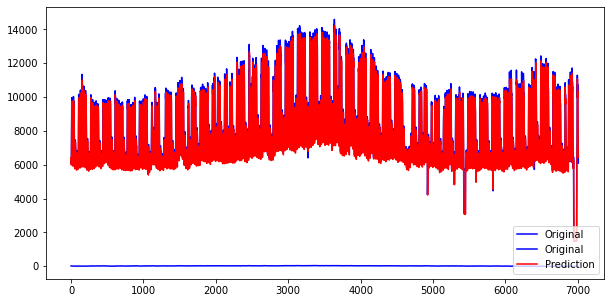

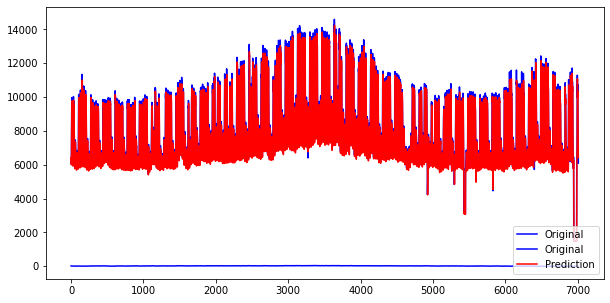

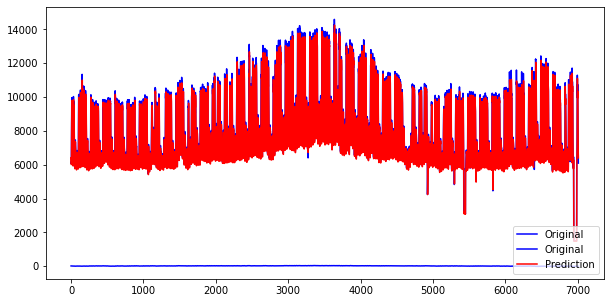

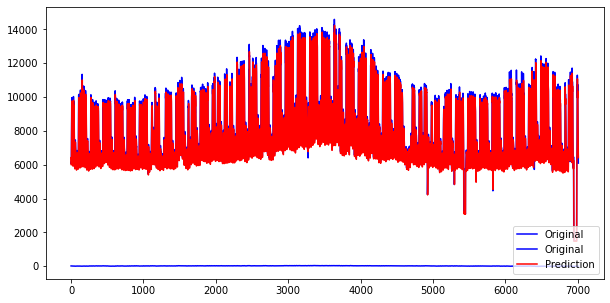

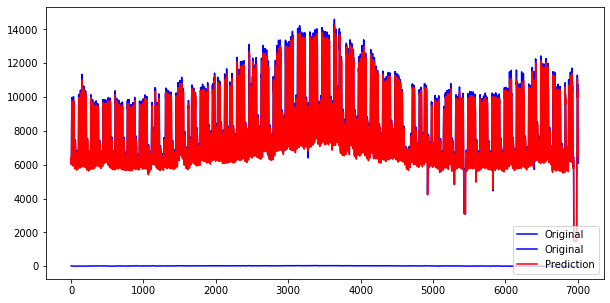

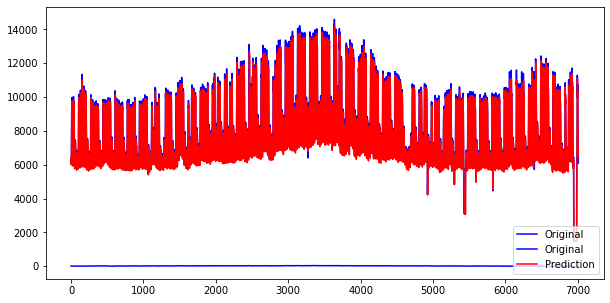

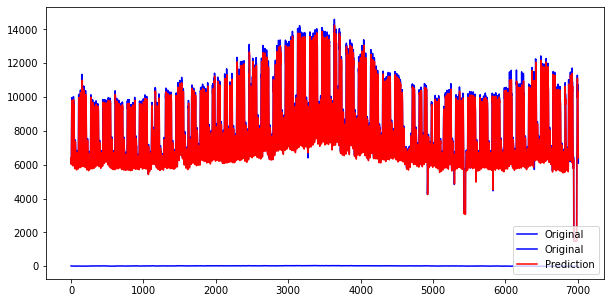

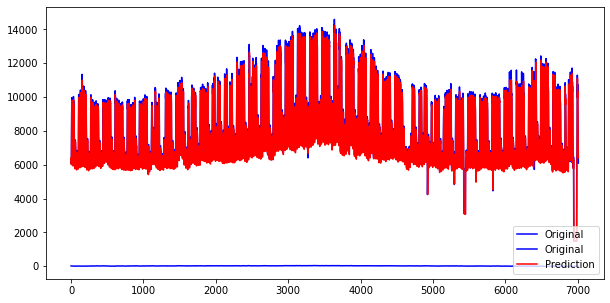

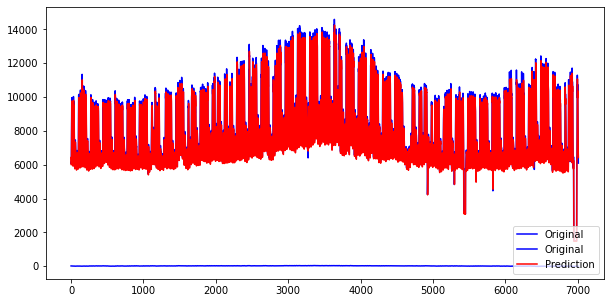

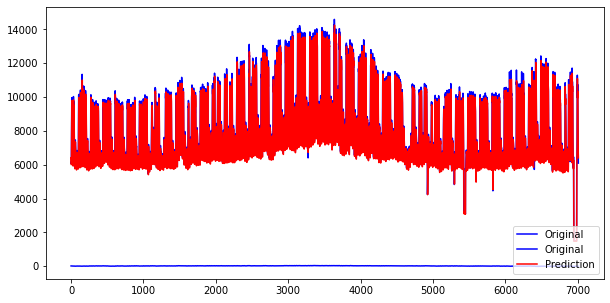

In [ ]:
# data split
n_test = 2

# define config 
# n seq: The number of subsequences within a sample.
# n steps: The number of time steps within each subsequence.
# n filters: The number of parallel filters.
# n kernel: The number of time steps considered in each read of the input sequence.
# n nodes: The number of LSTM units to use in the hidden layer.
# n epochs: The number of times to expose the model to the whole training dataset.
# n batch: The number of samples within an epoch after which the weights are updated.

config = [1, 2, 64, 3, 200, 350, 100]
# grid search
scores = repeat_evaluate(data2, config, n_test)
# summarize scores
summarize_scores('cnn-lstm', scores)